In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip

In [2]:
population = pd.read_csv("../data/curated/final_population.csv")

In [3]:
population

,sa2_name,year,erp
0,abbotsford,2016,8770
1,abbotsford,2017,9291
2,abbotsford,2018,9527
3,abbotsford,2019,9594
4,abbotsford,2020,9672
...,...,...,...
6187,yuroke,2023,31976
6188,yuroke,2024,35067
6189,yuroke,2025,38092
6190,yuroke,2026,41053


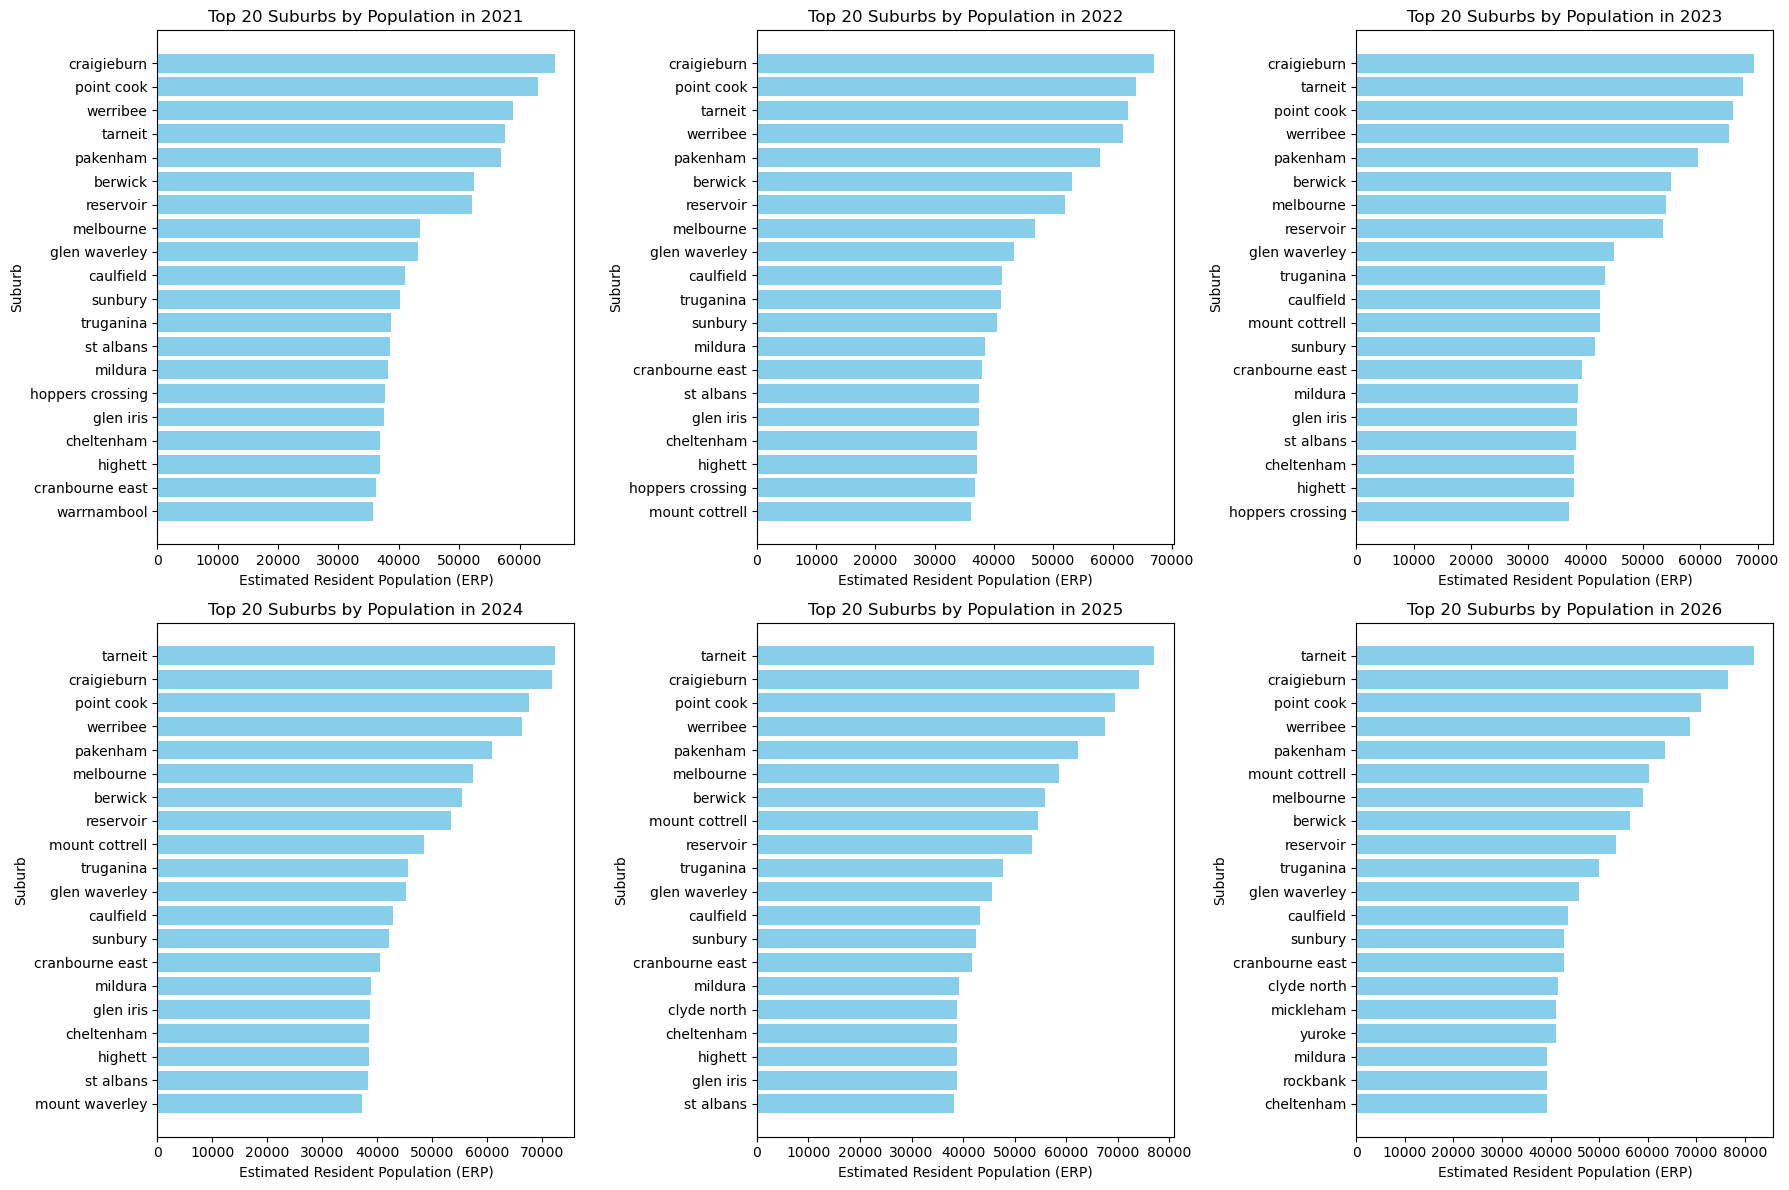

In [4]:
# Define the range of years to visualize
years_to_plot = range(2021, 2027)

# Create a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Loop through each year and its respective subplot
for i, year_to_plot in enumerate(years_to_plot):
    # Filter the data for the specific year
    subset = population[population['year'] == year_to_plot]

    # Sort the data by population size and select the top 20 suburbs
    top_20 = subset.nlargest(20, 'erp')

    # Create the bar plot for the top 20 suburbs on the respective subplot
    axes[i].barh(top_20['sa2_name'], top_20['erp'], color='skyblue')
    axes[i].set_xlabel('Estimated Resident Population (ERP)')
    axes[i].set_ylabel('Suburb')
    axes[i].set_title(f'Top 20 Suburbs by Population in {year_to_plot}')
    axes[i].invert_yaxis()  # To have the highest value at the top

# Adjust layout so plots do not overlap
plt.tight_layout()
plt.savefig("../plots/most_populated_suburbs.png")
plt.show()

In [5]:
# Load Victoria suburbs shapefile for filtering
vic_suburbs_gdf = gpd.read_file('../data/map/Vic_Localities/gda2020_vicgrid/esrishape/whole_of_dataset/victoria/VMADMIN/LOCALITY_POLYGON.shp')
vic_suburbs_gdf = vic_suburbs_gdf.to_crs(epsg=4326)
vic_suburbs_gdf['suburb'] = vic_suburbs_gdf['GAZLOC'].str.lower()

In [6]:
# Merge the population data with the suburbs shapefile
merged = vic_suburbs_gdf.merge(population, left_on='suburb', right_on='sa2_name')

# Drop unnecessary datetime columns (if not needed)
merged = merged.drop(columns=['PFI_CR', 'UFI_OLD', 'UFI_CR'], errors='ignore')

# Choose a specific year to visualize (e.g., 2023)
year_to_plot = 2023
merged_year = merged[merged['year'] == year_to_plot]

# Create a Folium map centered on Victoria (Melbourne area)
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=10, tiles="cartodb positron")

# Add the choropleth map for population with a better color scheme and highlight on hover
choropleth = folium.Choropleth(
    geo_data=merged_year.__geo_interface__,    # Geopandas dataframe in GeoJSON format
    data=merged_year,                          # Dataframe with population data
    columns=['sa2_name', 'erp'],               # Column to map (suburb names and population)
    key_on='feature.properties.suburb',        # Suburb name from GeoDataFrame (check this name)
    fill_color='YlOrRd',                       # Adjusted color scheme for better visual contrast
    fill_opacity=0.7,                          # Transparency of the color
    line_opacity=0.2,                          # Transparency of the borders
    highlight=True,                            # Enable highlighting when hovered
    legend_name=f'Population in {year_to_plot}' # Legend for the map
).add_to(m)

# Add tooltips to display suburb and population on hover
tooltip = GeoJsonTooltip(
    fields=['suburb', 'erp'],
    aliases=['Suburb:', 'Population:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """
)

# Apply the tooltip to the GeoJson layer
folium.GeoJson(
    merged_year.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0
    },
    tooltip=tooltip
).add_to(m)

# Add interactive elements like LayerControl
folium.LayerControl().add_to(m)

# Save the map to an HTML file or display it directly in Jupyter Notebook
m.save('../plots/population_map.html')

# To display directly in Jupyter Notebook (if running there):
# m